In [10]:
#All the imports and data import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns

import os, sys

cwd = os.getcwd()
URI = (cwd+"\\train.csv")
#URI = (cwd+"\\train_standardscaler.csv")
#URI = (cwd+"\\train_minmaxscaler.csv")
film_data = pd.read_csv(URI, dtype={"Lead":str}).dropna().reset_index(drop=True)

#Creating dummy values of the category "Lead"
film_data_dummies = pd.get_dummies(film_data).copy()

#Adding two columns that summerizes the number of words M/F with the lead's words if the same gender
film_data_dummies = film_data_dummies.assign(total_words_male=lambda row: (row['Number words male'] + row['Number of words lead'] * row['Lead_Male']))
film_data_dummies = film_data_dummies.assign(total_words_female=lambda row: (row['Number words female'] + row['Number of words lead'] * row['Lead_Female']))


#Only saving "Lead_Male" as category and renaming it to "Lead"
film_data_dummies.drop("Lead_Female",1, inplace=True)
y = film_data_dummies['Lead_Male'].rename("Lead")
x = film_data_dummies.drop(columns=['Lead_Male'])


C:\Users\Felix\AppData\Local\Temp\ipykernel_9844\3449871578.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  film_data_dummies.drop("Lead_Female",1, inplace=True)


In [ ]:
#film_data.sort_values(by=["Year"]).head()
film_data.head()
#film_data.info()
#film_data.describe()
#film_data.skew(axis=0)


In [11]:
#removing the k worst performing data
selector = SelectKBest(chi2, k=8).fit(x, y).get_support()

x_new = x.iloc[:,selector]
x_discarded = x.iloc[:,~selector]

#rCreating new dataframe with chosen features f
film_data_new = x_new.copy()
film_data_new.insert(loc=film_data_new.shape[1],column="Lead", value= y.to_frame())


In [ ]:
#removing the worst performing data
#selector = SelectKBest(chi2, k=5).fit(x, y).get_support()




n_of_features = 8 #number of features you want eventually
disregarded_order = {} #In which order the disregared features where removed

disregarded_columns = []
for i in range(1,x.shape[1]-n_of_features):
    K = x.shape[1]-i
    selector = SelectKBest(chi2, k=K).fit(x, y).get_support()
    col_temp = x.iloc[:,~selector].columns.values.tolist()
    for name in col_temp:
        if ( name not in disregarded_columns):
            disregarded_order.update({name:i})
    disregarded_columns = col_temp

print(disregarded_order)


In [ ]:
pd.plotting.scatter_matrix(x_new,figsize=(12,10))

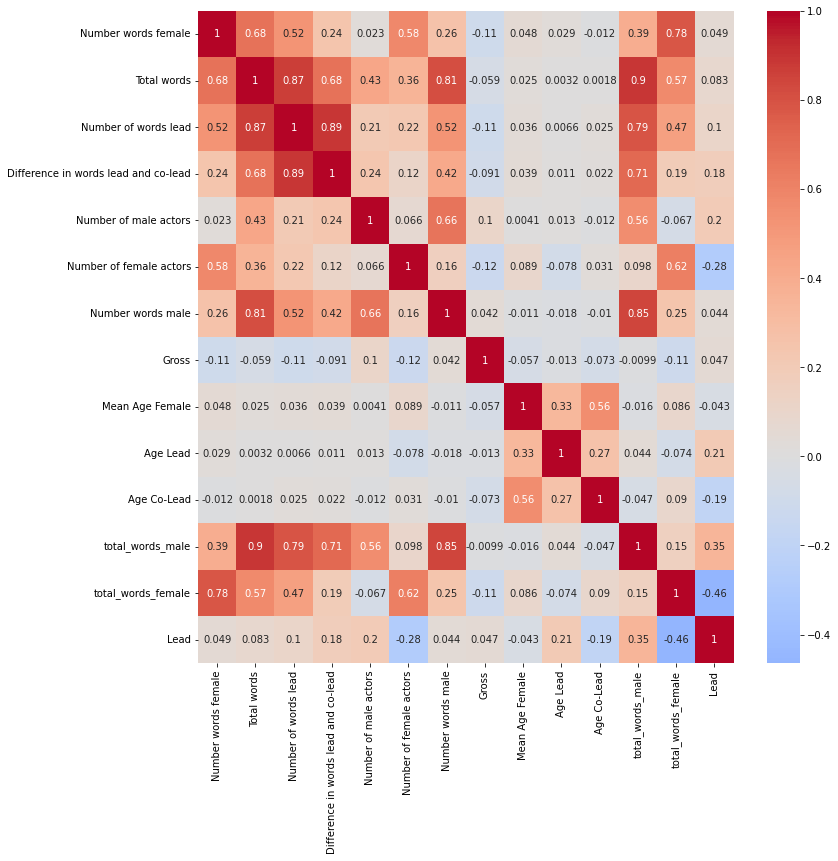

In [9]:
#Heatmap with new dataset correlation
plt.figure(figsize=(12,12))
cor = film_data_new.corr()
sns.heatmap(cor, annot=True, cmap="coolwarm",center=0.0)
plt.show()


In [ ]:

pd.plotting.radviz(film_data_new,"Lead")

plt.show()

In [ ]:
#film_data.plot.scatter(x="Year",y="Number words female")

ax1 = film_data_dummies.plot(kind='scatter', x='Year', y='total_words_female', color='r')    
ax2 = film_data_dummies.plot(kind='scatter', x='Year', y='total_words_male', color='g', ax=ax1)    


plt.show()


In [ ]:

df = film_data.groupby("Year")["Gross"].mean()

df.plot()
plt.show()


In [ ]:
#Yearly avg nr spoken words per film
df = film_data_dummies.groupby("Year", as_index=True).mean()
df.reset_index(inplace=True)

df1 = df.plot(kind="scatter", y="total_words_male",x="Year", color="b", label="Avg nr male words")
df2 = df.plot(kind="scatter", y="total_words_female",x="Year", color="r", ax=df1, xlabel="Year", label="Avg nr female words", \
    title="Yearly avg nr spoken words per film", figsize=(9,9))
plt.show()


In [ ]:
#CREATE NEW DATA WITH STANDARDSCALING
x = film_data.drop(columns=['Lead'])
y = film_data['Lead']

standard_scaler = skl_pre.StandardScaler(with_mean=True,with_std=True)

# StandardScaler: mean=0, variance=1
scaled_film_data_array = standard_scaler.fit_transform(x)

x_scaled = pd.DataFrame(scaled_film_data_array, columns = list(x.columns))

film_data_scaled = x_scaled.join(y)

#film_data_scaled.to_csv('train_standardscaler.csv',index=False)

In [ ]:
#CREATE NEW DATA WITH MINMAXSCALER
x = film_data.drop(columns=['Lead'])
y = film_data['Lead']

minmax_scaler = skl_pre.MinMaxScaler(feature_range=(0,1))

# MinMax scaler: min=0, max=1
scaled_film_data_array = minmax_scaler.fit_transform(x)

x_scaled = pd.DataFrame(scaled_film_data_array, columns = list(x.columns))

film_data_scaled = x_scaled.join(y)

#film_data_scaled.to_csv('train_minmaxscaler.csv', index=False)

Answers to questions 3

Do men or women dominate speaking roles in Hollywood movies? 

• Has gender balance in speaking roles changed over time (i.e. years)? 

• Do films in which men do more speaking make a lot more money than films in which women speak more?

In [ ]:
#Spoken word to movie gross
df = film_data_dummies.copy()

plt.figure(figsize=(8, 8))
ax_male_word_gross = plt.scatter(df["Gross"], df["total_words_male"], color="b", label="Number of Male words to movie gross")
ax_female_word_gross = plt.scatter(df["Gross"], df["total_words_female"], color="r", label="Number of Female words to movie gross")
plt.xlabel("Gross")
plt.ylabel("Words")
plt.title("M/F number of words to gross")
plt.legend()
plt.show()


In [ ]:
#NUMBER OF FILMS WITH M/F LEAD
df_male = film_data.loc[film_data['Lead'] == "Male",]
df_female = film_data.loc[film_data['Lead'] == "Female"]

df_male_leads = df_male.groupby("Year", as_index=True)["Lead"].count()
df_female_leads = df_female.groupby("Year", as_index=True)["Lead"].count()
df_number_films = film_data.groupby("Year", as_index=True)["Lead"].count()


df_male_leads.columns = ["Year", "Films with male lead"]
df_female_leads.columns = ["Year", "Films with female lead"]


df1 = df_number_films.plot(kind="line", y="Lead",x="Year", color="g", label="Total number of analyzed films")
df2 = df_male_leads.plot(kind="line", y="Films with male lead",x="Year", color="b", label="Nr films with male lead", ax=df1)
df3 = df_female_leads.plot(kind="line", y="Films with female lead",x="Year", color="r", label="Nr films with female lead", ax=df2, xlabel="Year", title="Number of films with leads m/f per year", figsize=(12,8))
plt.legend()

plt.show()


In [ ]:
#NUMBER OF M/F actors avg per film

df_male_actors = df_male.groupby("Year", as_index=True)["Number of male actors"].mean()
df_female_actors = df_female.groupby("Year", as_index=True)["Number of female actors"].mean()


df_male_actors.columns = ["Year", "Number of male actors"]
df_female_actors.columns = ["Year", "Number of female actors"]

df2 = df_male_actors.plot(kind="line", y="Number of male actors",x="Year", color="b", label="Number of Male actors")
df3 = df_female_actors.plot(kind="line", y="Number of female actors",x="Year", color="r", label="Number of Male actors", ax=df2, xlabel="Year", title="Mean of M/F actors per film (yearly avg)")

plt.legend()
plt.figure(figsize=(20,8))
plt.show()

In [ ]:
#average nr spoken words (M/F) per film per year
df = film_data_dummies.copy()

df_avg_male_words = df.groupby("Year")["total_words_male"].mean()
df_avg_female_words = df.groupby("Year")["total_words_female"].mean()
df_avg_total_words= df.groupby("Year")["Total words"].mean()

df_avg_total_words_plot = df_avg_total_words.plot(kind="line", y="Total words", x="Year", color="g", label="Avg number of words per film")
df_avg_male_words_plot = df_avg_male_words.plot(kind="line", y="total_words_male", x="Year", color="b", label="Avg number of Male words per film", ax=df_avg_total_words_plot)
df_avg_female_words_plot = df_avg_female_words.plot(kind="line", y="total_words_female", x="Year", color ="r",label="Avg number of Female words per film", xlabel="Year", ylabel="Avg spoken words", title="Avg number of spoken of words per year", ax=df_avg_male_words_plot, figsize=(14,8))
plt.legend()
plt.show()


In [ ]:
#Proportion of spoken words (M/F) per film per year
def proportion(x, y):
    x_new = x/(y)
    return x_new

df = film_data_dummies.copy()

df['Proportion female words'] = df.apply(lambda row : proportion(row['total_words_female'],row['Total words']), axis = 1)
df['Proportion male words'] = df.apply(lambda row : proportion(row['total_words_male'], row['Total words']), axis = 1)

df_male_words_proportion = df.groupby("Year")["Proportion male words"].mean()
df_female_words_proportion = df.groupby("Year")["Proportion female words" ].mean()

df_male_words_proportion_plot = df_male_words_proportion.plot(kind="line", y="Proportion male words", x="Year", color="b", label="Mean proportion of Male words per year")
df_female_words_proportion_plot = df_female_words_proportion.plot(kind="line", y="Proportion female words", x="Year", color ="r", \
    label="Mean proportion of Female words per year", xlabel="Year", ylabel="Proportion spoken words", title="Proportion of words spoken (M/F) per year", \
        ax=df_male_words_proportion_plot, figsize=(12,10))
plt.legend()
plt.show()


In [ ]:
#ALL PLOTS IN ONE
#Spoken word to movie gross
df = film_data_dummies.copy()
#df= df.groupby("Gross")["total_words_male"].mean()

plt.subplot(2,2,1)
ax_male_word_gross = plt.scatter(df["Gross"], df["total_words_male"], color="b", label="Number of Male words to movie gross")
ax_female_word_gross = plt.scatter(df["Gross"], df["total_words_female"], color="r", label="Number of Female words to movie gross")
plt.xlabel("Gross")
plt.ylabel("Words")
plt.title("M/F number of words to gross")
plt.legend()

df = film_data_dummies.copy()

#average nr spoken words (M/F) per film per year
df_avg_male_words = df.groupby("Year")["total_words_male"].mean()
df_avg_female_words = df.groupby("Year")["total_words_female"].mean()
df_avg_total_words= df.groupby("Year")["Total words"].mean()
plt.legend()

plt.subplot(2,2,2)
df_avg_total_words_plot = df_avg_total_words.plot(kind="line", y="Total words", x="Year", color="g", label="Avg number of words per film")
df_avg_male_words_plot = df_avg_male_words.plot(kind="line", y="total_words_male", x="Year", color="b", label="Avg number of Male words per film", ax=df_avg_total_words_plot)
df_avg_female_words_plot = df_avg_female_words.plot(kind="line", y="total_words_female", x="Year", color ="r",label="Avg number of Female words per film", xlabel="Year", ylabel="Avg spoken words", title="Avg number of spoken of words per year", ax=df_avg_male_words_plot)
plt.legend()


#Proportion of spoken words (M/F) per film per year
def proportion(x, y):
    x_new = x/(y)
    return x_new

df['Proportion female words'] = df.apply(lambda row : proportion(row['total_words_female'],row['Total words']), axis = 1)
df['Proportion male words'] = df.apply(lambda row : proportion(row['total_words_male'], row['Total words']), axis = 1)

df_male_words_proportion = df.groupby("Year")["Proportion male words"].mean()
df_female_words_proportion = df.groupby("Year")["Proportion female words" ].mean()

plt.subplot(2,2,3)
df_male_words_proportion_plot = df_male_words_proportion.plot(kind="line", y="Proportion male words", x="Year", color="b", label="Mean proportion of Male words per year")
df_female_words_proportion_plot = df_female_words_proportion.plot(kind="line", y="Proportion female words", x="Year", color ="r", \
    label="Mean proportion of Female words per year", xlabel="Year", ylabel="Proportion spoken words", title="Proportion of words spoken (M/F) per year", \
        ax=df_male_words_proportion_plot)
plt.legend()


#NUMBER OF M/F actors avg per film
df_male_actors = df.groupby("Year", as_index=True)["Number of male actors"].mean()
df_female_actors = df.groupby("Year", as_index=True)["Number of female actors"].mean()

df_male_actors.columns = ["Year", "Number of male actors"]
df_female_actors.columns = ["Year", "Number of female actors"]

plt.subplot(2,2,4)
df2 = df_male_actors.plot(kind="line", y="Number of male actors",x="Year", color="b", label="Number of Male actors")
df3 = df_female_actors.plot(kind="line", y="Number of female actors",x="Year", color="r", label="Number of Male actors", ax=df2, xlabel="Year", ylabel="Actors", title="Mean of M/F actors per film (yearly avg)",figsize=(15,10))


plt.legend()
plt.show()